In [240]:
import pandas as pd
import numpy as np
import json
import re
from llms import gemini
from llms import chatGPT
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting
import plotly.express as px
from sklearn.manifold import TSNE
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from reportlab.lib.utils import ImageReader
import plotly.io as pio


x_chat = chatGPT()
x_gemini = gemini()

In [241]:
df = pd.read_csv("../output/bls_df.csv",index_col=0)
tsne = pd.read_csv("../output/tsne.csv",index_col=0)
df = pd.concat([df,tsne],axis=1)

# df.example_task_embedding = df.example_task_embedding.apply(lambda x: [float(y) for y in x.strip("[]").split(", ")])
# df.onet_task_embedding = df.onet_task_embedding.apply(lambda x: [float(y) for y in x.strip("[]").split(", ")])
# df.onet_title_embedding = df.onet_title_embedding.apply(lambda x: [float(y) for y in x.strip("[]").split(", ")])



In [242]:


wage_employment = pd.read_csv("../input/wage_employment2022/national2022.csv")
wage_employment = wage_employment[wage_employment.O_GROUP == "detailed"]
wage_employment = wage_employment.rename({"OCC_CODE": "Detailed Occupation"}, axis=1)
wage_employment = wage_employment.replace("#", np.nan).replace("*", np.nan).replace({",": ""}, regex=True)
wage_employment[["H_MEDIAN", "A_MEDIAN","TOT_EMP","JOBS_1000"]] = wage_employment[["H_MEDIAN", "A_MEDIAN","TOT_EMP","JOBS_1000"]].astype("float")
wage_employment["H_MEDIAN"] = wage_employment["H_MEDIAN"].round(0)
wage_employment = wage_employment[["Detailed Occupation","H_MEDIAN","A_MEDIAN","TOT_EMP","JOBS_1000"]]
wage_employment.columns = ["Detailed Occupation","H_MEDIAN_US","A_MEDIAN_US","TOT_EMP_US","JOBS_1000_US"]


all_tasks = df.groupby("Task").aggregate({"onet_weight":"sum"}).reset_index()
task_statements = pd.read_csv("../input/onet/Task Statements.csv")[["Task","Title"]]
all_tasks = all_tasks.merge(task_statements, on=["Task"], how="outer")
onet_occ = pd.read_csv("../input/onet/Occupation Data.csv")[["O*NET-SOC Code","Title"]]
onet_occ.columns = ["Detailed Occupation","onet_title"]
onet_occ["Detailed Occupation"] = onet_occ["Detailed Occupation"].apply(lambda x: x[:-3])
all_tasks = all_tasks.merge(onet_occ, left_on="Title",right_on="onet_title").drop(columns=["Title"])

all_tasks = all_tasks.replace(np.nan,0)
perc_of_10K = (wage_employment.groupby("Detailed Occupation")["TOT_EMP_US"].first()/df["TOT_EMP_US"].sum() * 10000).reset_index() # num of people for every 10K workers
perc_of_10K = perc_of_10K.rename({"TOT_EMP_US":"Percent of 10K workers"},axis=1)


all_tasks = all_tasks.merge(perc_of_10K, on="Detailed Occupation")
ratios = all_tasks['onet_weight'] / all_tasks['Percent of 10K workers']
all_tasks["automated_weight"] = np.minimum(ratios, 1)


all_occupations = all_tasks.groupby("Detailed Occupation").aggregate({"automated_weight":"sum","Task":"count", "onet_title":"first"})
all_occupations.columns = ["occupation_# tasks automated","occupation_# of tasks","onet_title"]
all_occupations["occupation_onet_rating"] = all_occupations["occupation_# tasks automated"]/all_occupations["occupation_# of tasks"]
df = df.merge(all_tasks[["Task","automated_weight","Percent of 10K workers"]], on="Task")
df = df.merge(all_occupations,on=["Detailed Occupation","onet_title"])



all_occupations = all_occupations.merge(wage_employment, on="Detailed Occupation")
all_tasks = all_tasks.merge(wage_employment, on="Detailed Occupation")
all_tasks = all_tasks.rename({"Title":"onet_title"},axis=1)

In [243]:
codes = pd.read_csv("../input/soc_codes/soc_codes.csv", index_col=0)
all_occupations = all_occupations.merge(codes,on="Detailed Occupation")
all_tasks = all_tasks.merge(codes,on="Detailed Occupation")

In [257]:
dwa = pd.read_csv("../input/onet/Tasks to DWAs.csv")[3:].reset_index(drop=True)
dwa = dwa[["DWA ID","DWA Title","Task"]]
# dwa = dwa.rename({"ID":"Task ID"},axis=1)
grouped = dwa.groupby("Task").aggregate({"DWA ID":"count"}).apply(lambda x: 1/x).reset_index()
grouped = grouped.rename({"DWA ID":"dwa_count"},axis=1)
dwa = dwa.merge(grouped,on="Task")
dwa_ref = pd.read_csv("../input/onet/DWA Reference.csv")[["Element Name","DWA ID"]]
dwa_ref = dwa_ref.rename({"Element Name":"activity"},axis=1)

tf = df.merge(dwa, on="Task",how="left")
tf = tf.merge(dwa_ref, on="DWA ID",how="left")
print(len(tf[tf["DWA ID"].isnull()]))

print(len(tf))

37
235824


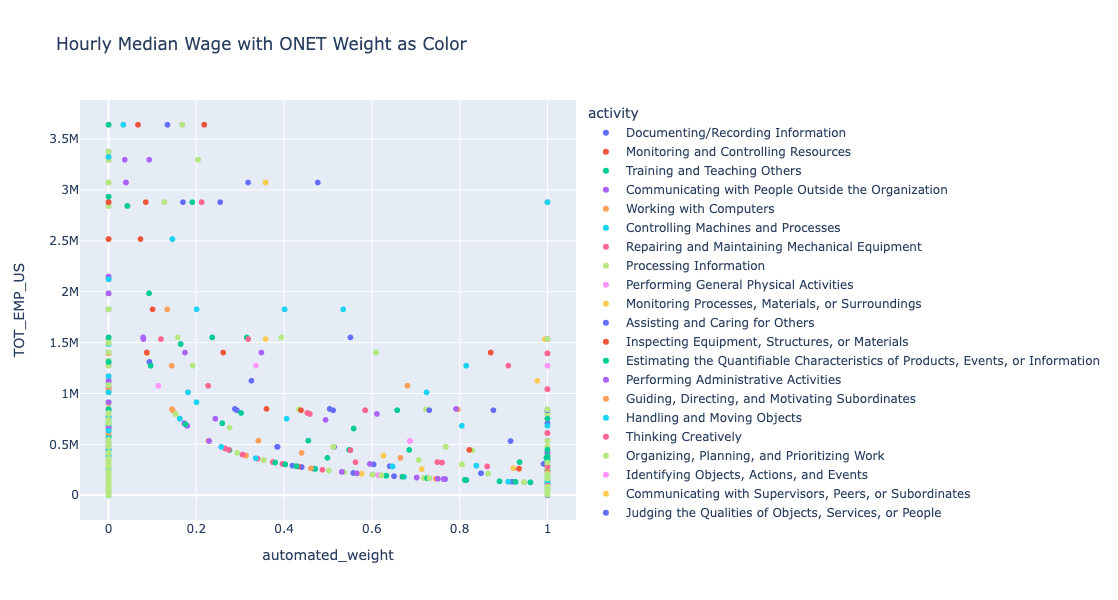

In [224]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting
import plotly.express as px

all_tasks_dwa = all_tasks.merge(dwa, on="Task",how="left")
all_tasks_dwa = all_tasks_dwa.merge(dwa_ref, on="DWA ID",how="left")

fig = px.scatter(
    all_tasks_dwa, x='automated_weight', y='TOT_EMP_US',
    color="activity",
    labels={
        'H_MEDIAN_US': 'Hourly Median Wage'
    },
    hover_name='onet_title',
    title=f'Hourly Median Wage with ONET Weight as Color'
)
fig.update_layout(
    coloraxis_colorbar=dict(title="rating"),
    autosize=False,
    width=1000,
    height=600
)
fig.show()

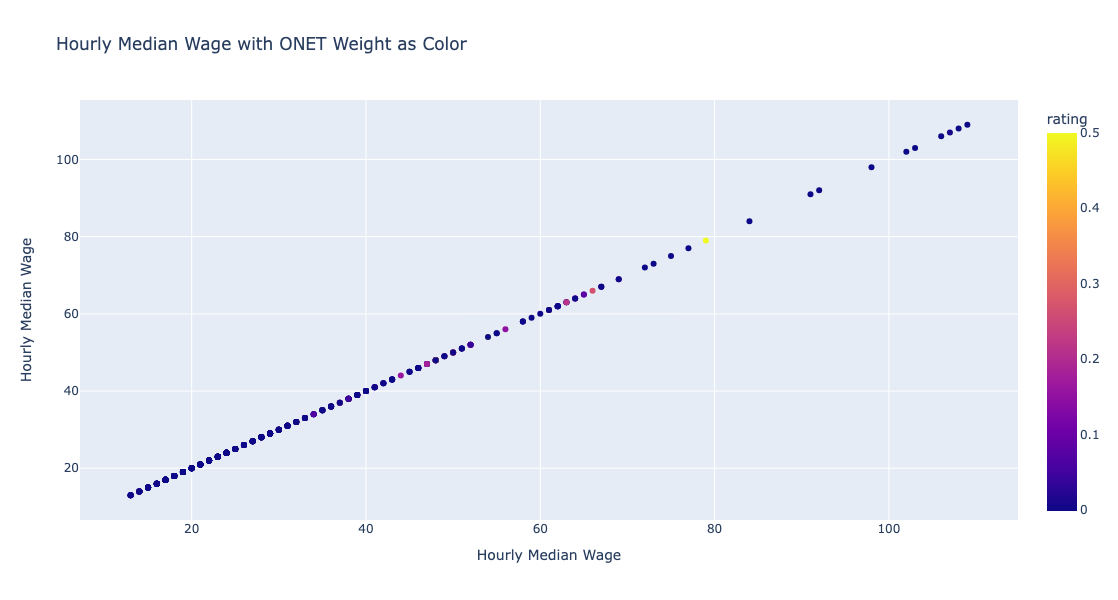

In [229]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting
import plotly.express as px



fig = px.scatter(
    all_occupations,
    x='H_MEDIAN_US',
    y='H_MEDIAN_US',
    color="occupation_onet_rating",
    labels={
        'H_MEDIAN_US': 'Hourly Median Wage'
    },
    hover_name='onet_title',
    title=f'Hourly Median Wage with ONET Weight as Color',
    range_color=(0, .5)
)
fig.update_layout(
    coloraxis_colorbar=dict(title="rating"),
    autosize=False,
    width=800,
    height=600
)
fig.show()


In [65]:
colors = px.colors.qualitative.Plotly
element_counts = tf["activity"].value_counts()
color_map_activity = {element: colors[i % len(colors)] for i, element in enumerate(element_counts.index)}

element_counts = tf["skill"].value_counts()
color_map_skill = {element: colors[i % len(colors)] for i, element in enumerate(element_counts.index)}


In [1]:
# occ_groups = list(tf.groupby("Major Group Name")["dwa_count"].sum().sort_values(ascending=False).index)

# values = ["TOT_EMP_US","H_MEDIAN_US","A_MEDIAN_US","activity","skill"]
# for occ_group in occ_groups[:4]:
#     for value in values:
#         print(value)
#         graph_df = tf[tf["Major Group Name"] == occ_group]
#         graph_df.head()
#         if value == "skill":
#             color_map = color_map_skill
#         else:
#             color_map = color_map_activity
#         # Plot using Plotly with clusters
#         fig = px.scatter(graph_df, x='onet_task_embedding_tsne1', y='example_task_embedding_tsne2',
#                          color=value,
#                          hover_data=['onet_task','job'],
#                          color_discrete_map=color_map,
#                          labels={value: 'Value'})
#         fig.update_traces(marker_size=10)                  
        
#         fig.update_layout(
#             title=f"{occ_group} {value}", 
#             hovermode='closest',
#             width=1000,  # Set the width of the figure
#             height=600,  # Set the height of the figure
#             legend=dict(font=dict(size=8)),
#         )
#         fig.show()

In [202]:
bins = [0, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000, 85000, 90000, 95000, 100000]
labels = ['<30k', '30k-35k', '35k-40k', '40k-45k', '45k-50k', '50k-55k', '55k-60k', '60k-65k', '65k-70k', '70k-75k', '75k-80k', '80k-85k', '85k-90k', '90k-95k', '95k-100k']
bins = [0,30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]
labels = ['<30k', '30k-40k', '40k-50k', '50k-60k', '60k-70k', '70k-80k', '80k-90k', '90k-100k']


# Create a new column 'H_MEDIAN_US_Bucket' with the bucket labels
all_occupations['A_MEDIAN_US_Bucket'] = pd.cut(all_occupations['A_MEDIAN_US'], bins=bins, labels=labels, right=False)

# Group by 'H_MEDIAN_US_Bucket' and 'Detailed_Occupation'
grouped = all_occupations.groupby(['A_MEDIAN_US_Bucket','Minor Group Name']).agg({
    'occupation_onet_rating': 'sum',
    'Detailed Occupation': 'count'
}).rename(columns={'Detailed Occupation': 'count'})

# # Calculate the percentage likelihood to be automated
grouped['percent_likely_automated'] = grouped['occupation_onet_rating'] / grouped['count']

# Reset index to make the DataFrame easier to read
grouped = grouped.reset_index().dropna()
grouped["label"]=grouped["Minor Group Name"] + " " + grouped["A_MEDIAN_US_Bucket"].astype("string")

/var/folders/nf/2dvvlnxj5v962kwwzmpfj17h0000gn/T/ipykernel_1221/347545737.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



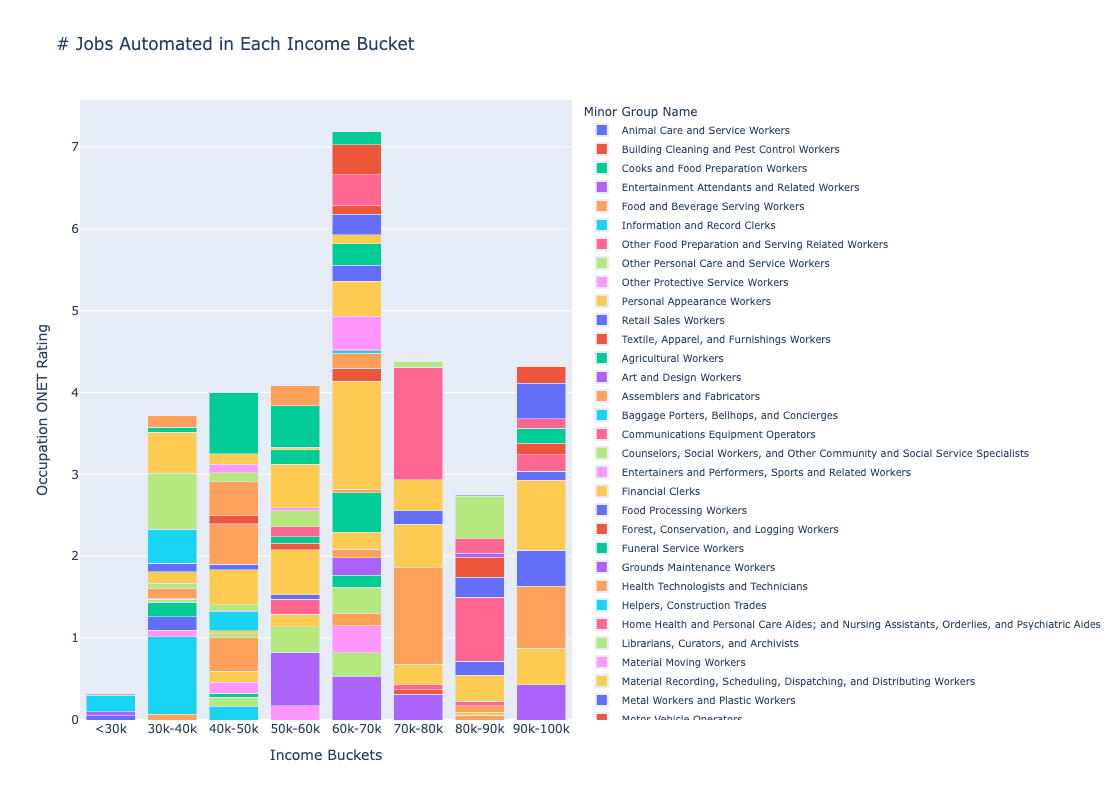

In [217]:
# Create the interactive plot
fig = px.bar(grouped, 
             x='A_MEDIAN_US_Bucket', 
             y='occupation_onet_rating', 
             color='Minor Group Name', 
             title='# Jobs Automated in Each Income Bucket',
             labels={'A_MEDIAN_US_Bucket': 'Income Buckets', 'occupation_onet_rating': 'Occupation ONET Rating'})

# Update layout for better visualization
fig.update_layout(barmode='stack')
fig.update_layout(legend=dict(font=dict(size=10), itemsizing='constant'), width=1000, height=800)
fig.update_layout(xaxis={'categoryorder':'array', 'categoryarray':labels})

# Display the plot
fig.show()
pio.write_html(fig, file='# Jobs Automated in Each Income Bucket.html', auto_open=True)


In [136]:
grouped

A_MEDIAN_US_Bucket                                   Major Group Name  \
16                <30k      Office and Administrative Support Occupations   
17                <30k              Personal Care and Service Occupations   
20                <30k                      Sales and Related Occupations   
24             30k-40k  Building and Grounds Cleaning and Maintenance ...   
26             30k-40k           Community and Social Service Occupations   
..                 ...                                                ...   
159           90k-100k              Computer and Mathematical Occupations   
164           90k-100k  Healthcare Practitioners and Technical Occupat...   
168           90k-100k     Life, Physical, and Social Science Occupations   
169           90k-100k                             Management Occupations   
174           90k-100k                      Sales and Related Occupations   

     occupation_onet_rating  count  percent_likely_automated  
16                 9.183709     12                  0.765309  
17                 2.759749      6                  0.459958  
20                 0.548839      6                  0.091473  
24                 0.329785      2                  0.164892  
26                 0.754578      3                  0.251526  
..                      ...    ...                       ...  
159               59.233531     68                  0.871081  
164                3.937047      6                  0.656174  
168                2.000000      2                  1.000000  
169               81.830640     95                  0.861375  
174               43.000000     43                  1.000000  

[76 rows x 5 columns]

/var/folders/nf/2dvvlnxj5v962kwwzmpfj17h0000gn/T/ipykernel_1221/2996179142.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



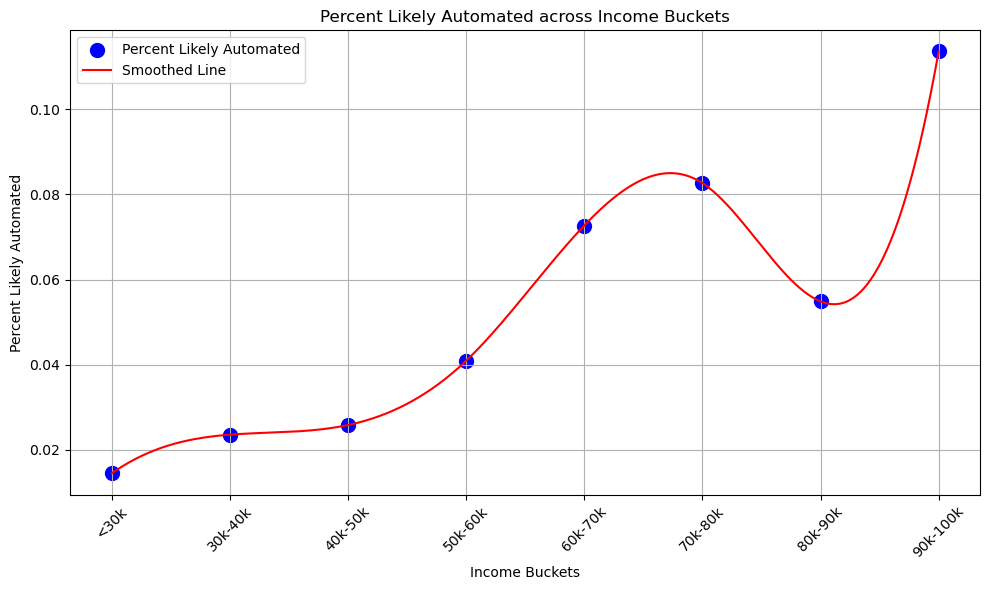

In [190]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline


grouped = all_occupations.groupby(['A_MEDIAN_US_Bucket']).agg({
    'occupation_onet_rating': 'sum',
    'Detailed Occupation': 'count'
}).rename(columns={'Detailed Occupation': 'count'}).reset_index()
grouped['percent_likely_automated'] = grouped['occupation_onet_rating'] / grouped['count']

x = np.arange(len(grouped['A_MEDIAN_US_Bucket']))


plt.figure(figsize=(10, 6))
plt.scatter(x, grouped['percent_likely_automated'], color='blue', label='Percent Likely Automated', s=100)

spl = make_interp_spline(x, grouped['percent_likely_automated'], k=3)  
x_smooth = np.linspace(x.min(), x.max(), 500)
y_smooth = spl(x_smooth)
plt.plot(x_smooth, y_smooth, color='red', label='Smoothed Line')

# Adding labels and title
plt.xlabel('Income Buckets')
plt.ylabel('Percent Likely Automated')
plt.xticks(x, grouped['A_MEDIAN_US_Bucket'], rotation=45)
plt.title('Percent Likely Automated across Income Buckets')
plt.legend()

# Displaying the plot
plt.tight_layout()
plt.grid(True)
plt.show()


In [118]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

x = np.arange(len(bins))

plt.figure(figsize=(10, 6))
plt.scatter(x, median_onet_rating, color='blue', label='Percent Likely to Be automated', s=100)

spl = make_interp_spline(x, median_onet_rating, k=3)  
x_smooth = np.linspace(x.min(), x.max(), 500)
y_smooth = spl(x_smooth)
plt.plot(x_smooth, y_smooth, color='red', label='Smoothed Line')

# Adding labels and title
plt.xlabel('Income Buckets')
plt.ylabel('Median ONET Rating')
plt.xticks(x, income_buckets, rotation=45)
plt.title('Median ONET Rating across Income Buckets')
plt.legend()

# Displaying the plot
plt.tight_layout()
plt.grid(True)
plt.show()


A_MEDIAN_US_Bucket  occupation_onet_rating  count  percent_likely_automated
0                <30k               12.492297     24                  0.520512
1             30k-35k               47.404084     92                  0.515262
2             35k-40k              202.965835    431                  0.470918
3             40k-45k               29.064191     53                  0.548381
4             45k-50k              171.722018    212                  0.810010
5             50k-55k               63.236676     71                  0.890657
6             55k-60k              166.120223    185                  0.897947
7             60k-65k              324.586852    470                  0.690610
8             65k-70k              160.740618    229                  0.701924
9             70k-75k              154.894104    161                  0.962075
10            75k-80k              183.392083    212                  0.865057
11            80k-85k               58.851081     88                  0.668762
12            85k-90k               29.843996     31                  0.962710
13            90k-95k                4.193525      8                  0.524191
14           95k-100k              649.981624    769                  0.845230

In [ ]:
tf

In [89]:
len(pd.read_csv("../input/onet/Tasks to DWAs.csv")["DWA Title"].unique())

2070

In [134]:
len(df)

14068

In [253]:
skill_activity = pd.read_csv("../input/onet/Skills to Work Activities.csv")[["Work Activities Element Name", "Skills Element Name"]]
skill_activity.columns = ["activity", "skill"]
activities_df = pd.DataFrame(columns=["activity", "activity_embedding", "skill", "skill_embedding"])
for i, row in skill_activity.iterrows():
    activity = row["activity"]
    skill = row["skill"]
    activity_embedding = x_chat.get_embedding(activity)
    skill_embedding = x_chat.get_embedding(skill)
    activities_df.loc[i] = [activity, activity_embedding, skill, skill_embedding]




activities_df.to_csv("../input/onet/activity_skill_embeddings.csv", index=False)



In [256]:
activities_df = pd.read_csv("../input/onet/activity_skill_embeddings.csv",index_col=0)
activities_df.activity_embedding = activities_df.activity_embedding.apply(lambda x: [float(y) for y in x.strip("[]").split(", ")])
activities_df.skill_embedding = activities_df.skill_embedding.apply(lambda x: [float(y) for y in x.strip("[]").split(", ")])

embeddings = np.vstack(activities_df['activity_embedding'].values)
tsne = TSNE(n_components=3, perplexity=100, n_iter=1000)
tsne_results = tsne.fit_transform(embeddings)
activities_df[["activity_embedding_tsne1","activity_embedding_tsne2"]] = tsne_results[:, [0,1]]

embeddings = np.vstack(activities_df['activity_embedding'].values)
tsne = TSNE(n_components=3, perplexity=100, n_iter=1000)
tsne_results = tsne.fit_transform(embeddings)
activities_df[["skill_embedding_tsne1","skill_embedding_tsne2"]] = tsne_results[:, [0,1]]

embeddings = np.vstack((activities_df['activity_embedding'] + activities_df['activity_embedding']).values)
tsne = TSNE(n_components=3, perplexity=100, n_iter=1000)
tsne_results = tsne.fit_transform(embeddings)
activities_df[["activity__skill_embedding_tsne1","activity_skill_embedding_tsne2"]] = tsne_results[:, [0,1]]

activities_df.head()

activity_embedding  \
activity                                                                                                
Getting Information                                 [-0.013447298668324947, 0.041387494653463364, ...   
Monitoring Processes, Materials, or Surroundings    [0.012626877054572105, 0.013225346803665161, -...   
Identifying Objects, Actions, and Events            [-0.015471739694476128, 0.015488873235881329, ...   
Judging the Qualities of Objects, Services, or ...  [-0.014280702918767929, -0.010409942828118801,...   
Processing Information                              [-0.012020192109048367, 0.021584542468190193, ...   

                                                                    skill  \
activity                                                                    
Getting Information                                 Reading Comprehension   
Monitoring Processes, Materials, or Surroundings    Reading Comprehension   
Identifying Objects, Actions, and Events            Reading Comprehension   
Judging the Qualities of Objects, Services, or ...  Reading Comprehension   
Processing Information                              Reading Comprehension   

                                                                                      skill_embedding  \
activity                                                                                                
Getting Information                                 [0.0015323176048696041, -0.0014972264179959893...   
Monitoring Processes, Materials, or Surroundings    [0.0015323176048696041, -0.0014972264179959893...   
Identifying Objects, Actions, and Events            [0.0015323176048696041, -0.0014972264179959893...   
Judging the Qualities of Objects, Services, or ...  [0.0014781919308006763, -0.0015292373718693852...   
Processing Information                              [0.001248258980922401, -0.0028923852369189262,...   

                                                    activity_embedding_tsne1  \
activity                                                                       
Getting Information                                                 6.258044   
Monitoring Processes, Materials, or Surroundings                   46.701950   
Identifying Objects, Actions, and Events                           83.108627   
Judging the Qualities of Objects, Services, or ...                 18.528126   
Processing Information                                             55.767693   

                                                    activity_embedding_tsne2  \
activity                                                                       
Getting Information                                                67.324883   
Monitoring Processes, Materials, or Surroundings                  -59.076126   
Identifying Objects, Actions, and Events                           60.135338   
Judging the Qualities of Objects, Services, or ...                 29.697517   
Processing Information                                             73.133675   

                                                    skill_embedding_tsne1  \
activity                                                                    
Getting Information                                            -25.571524   
Monitoring Processes, Materials, or Surroundings                -3.864846   
Identifying Objects, Actions, and Events                       -52.027428   
Judging the Qualities of Objects, Services, or ...             -57.265003   
Processing Information                                           9.787385   

                                                    skill_embedding_tsne2  \
activity                                                                    
Getting Information                                             96.186722   
Monitoring Processes, Materials, or Surroundings               -13.619327   
Identifying Objects, Actions, and Events                         1.280764   
Judging the Qualities of

In [258]:
tf = tf.merge(activities_df,on=["activity"], how="left")

# skill_activity = pd.read_csv("../input/onet/Skills to Work Activities.csv")[["Work Activities Element Name","Skills Element Name"]]
# skill_activity.columns = ["activity","skill"]
# tf = tf.merge(skill_activity, on="activity", how="left")

In [ ]:
all_tasks = all_tasks.merge(activities_df,on=["activity"], how="left")

In [251]:
len(tf)

355781

In [26]:
dwa["Task ID"] = dwa["Task ID"].astype("int")

In [259]:
occ_groups = list(tf.groupby("Major Group Name")["dwa_count"].sum().sort_values(ascending=False).index)

values = ["TOT_EMP_US","H_MEDIAN_US","A_MEDIAN_US","activity","skill"]
for occ_group in occ_groups[:4]:
    for value in values:
        print(value)
        graph_df = tf[tf["Major Group Name"] == occ_group]
        graph_df.head()
        if value == "skill":
            color_map = color_map_skill
        else:
            color_map = color_map_activity
        # Plot using Plotly with clusters
        fig = px.scatter(graph_df, x='onet_task_embedding_tsne1', y='activity_embedding_tsne1',
                         color=value,
                         hover_data=['onet_task','job'],
                         color_discrete_map=color_map,
                         labels={value: 'Value'})
        fig.update_traces(marker_size=10)                  
        
        fig.update_layout(
            title=f"{occ_group} {value}", 
            hovermode='closest',
            width=1000,  # Set the width of the figure
            height=600,  # Set the height of the figure
            legend=dict(font=dict(size=8)),
        )
        fig.show()

TOT_EMP_US


KeyboardInterrupt: 

In [ ]:
import plotly.express as px
import plotly.io as pio

# Filter the DataFrame to add text only if automated_weight is over 30
grouped['text_label'] = grouped.apply(lambda row: row['skill'] if row['automated_weight'] > 30 else '', axis=1)

# Assuming `grouped` is your DataFrame
fig = px.scatter(grouped, 
                 x='activity_embedding_tsne1', 
                 y='skill_embedding_tsne1',
                 color="automated_weight",
                 color_continuous_scale=px.colors.sequential.Viridis,
                 hover_data=['activity', 'skill'],
                 text='text_label',  # Add the filtered text labels
                 labels={'value': 'Value'},
                 range_color=(0, 50))

fig.update_traces(marker_size=10, textfont=dict(size=10), textposition='top center')                  

fig.update_layout(
    title=f"{occ_group} {value}", 
    hovermode='closest',
    width=1500,  # Set the width of the figure
    height=1000,  # Set the height of the figure
    legend=dict(font=dict(size=8)),
)

fig.show()
pio.write_html(fig, file='Skills Automated.html', auto_open=True)


In [ ]:
- socio economic status 
- hourly annual 
- pew research center website socio economic data
- location of jobs
- related occupation, group by most links
https://www.bls.gov/oes/tables.htm